# Assignment 1 - Michael Rice and Lorenz Krause

## Assignment Part 1

### Imports

In [2]:
import numpy as np 
import pandas as pd
import math 
from sklearn.model_selection import train_test_split
import random
import os
import cv2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm


### Loading Data

In [ ]:
#code from the sample provided
def load_dataset(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values  # Features (x1, x2, x3...)
    y = data.iloc[:, -1].values   # Labels (y)
    return X, y

linearly_separable_path = "D2_linearly_separable.csv"
non_linearly_separable_path = "D1_non_linearly_separable.csv"
features_3d_path = "D3_3d_features.csv"


X1, y1 = load_dataset(linearly_separable_path)
X2, y2 = load_dataset(non_linearly_separable_path)
X3, y3 = load_dataset(features_3d_path)

### Logistic Regression Implementation

#### Algorithmic Description



The block of code below implements a neural network approach to Logistic Regression or a 'One Layer Neural Network' with no hidden layers and only one output node. This is relatively straightforward in comparison to implementing hidden layers.

For our implementation, we followed an object Oriented Programming approach, having a Logistic Regressor class, with init, train, predict functions and more. The init function instantiated all class variables needed to train the model. The train method is the main area
of computation and operates as follows, in basic descriptive steps :
 - Define number of weights and randomly instantiate them.
 - Instantiate all stopping condition variables.
 - While stopping is not set :
   - Randomly select a single data point.
   - Compute y_hat, the activation of the dot product between the weights and the sample point, plus the bias.
   - Compute the log loss between the calculated y_hat value and the actual y value from the selected point. 
   - For each weight, compute the delta value and update each weight along with the learning rate. 
   - Add to the iteration count and check stopping conditions. If over max number of iterations, stop.
   - Otherwise, if we have been over all training data, this is the end of an epoch, so calculate the cost using the previously acquired log loss value and if the difference between this epoch's cost and the last's is less than a certain threshold, set the stop condition 
   to true also.
   

#### Algorithm

In [ ]:
# Lorenz
#stochastic GD implementation
class LogisticRegressor:

    def __init__(self, lr, stop_threshold, max_iterations):
        self.weights = None
        self.bias = None
        self.stop_threshold = stop_threshold
        self.max_iterations = max_iterations
        self.lr = lr

        #plotting storage
        self.training_data = []
        self.z_values = []
        self.predictions = []
        
    
    def train(self, X, y):
        num_weights = X.shape[1]

        self.weights = np.random.uniform(-1,1,num_weights) 
        self.bias = 0
        self.losses = []

        stopping = False
        running_cost = 0
        running_cost_prev = 0
        iteration = 0

        while not stopping:


            y = list(y)
            index = np.random.randint(0,len(X))

            sampx = X[index]
            sampy = y[index]

            yh = self.y_hat(self.weights, sampx, self.bias)
            ll = self.log_loss(yh,sampy)

            delta_w = []
            for i in range(len(self.weights)):
                delta_wj = (yh - sampy) * sampx[i]
                delta_w.append(delta_wj)
        
            delta_b = yh - sampy

            for i in range(len(self.weights)):
                self.weights[i] -= self.lr * delta_w[i]

            self.bias -= self.lr * delta_b

            iteration += 1
            running_cost += ll

            z_value = np.dot(sampx, self.weights) + self.bias
            self.z_values.append(z_value)
            self.predictions.append(1 if yh > 0.5 else 0)
            self.training_data.append((sampx, sampy)) 

            if iteration > self.max_iterations:
                stopping = True
            
            if iteration % len(X) == 0:
                dif = abs(running_cost - running_cost_prev)
                if dif < self.stop_threshold:
                    stopping = True
                running_cost = 0

            running_cost_prev = running_cost


    def predict(self, X, weights,bias):

        preds = []

        for i in range(len(X)):

            pred = self.y_hat(weights,X[i],bias)
            preds.append(1 if pred > 0.5 else 0)
        
        return preds 


    def y_hat(self, weights,X_point, bias):
        z = np.dot(X_point,weights) + bias
        return 1 / (1 + np.exp(-z))


    def log_loss(self,y_hat,y_point):
        return -((y_point * math.log(y_hat)) + (1 - y_point) * math.log(1 - y_hat))





#### Dataset Splitting

In [ ]:
# Michael
#train,test,validation splitting 
x1_train, x1_rest, y1_train, y1_rest = train_test_split(X1, y1, test_size=0.3)
x1_test, x1_val, y1_test, y1_val = train_test_split(x1_rest, y1_rest, test_size=0.5)

x2_train, x2_rest, y2_train, y2_rest = train_test_split(X2, y2, test_size=0.3)
x2_test, x2_val, y2_test, y2_val = train_test_split(x2_rest, y2_rest, test_size=0.5)

x3_train, x3_rest, y3_train, y3_rest = train_test_split(X3, y3, test_size=0.3)
x3_test, x3_val, y3_test, y3_val = train_test_split(x3_rest, y3_rest, test_size=0.5)


#### Accuracy and Fine-Tuning Functions

In [ ]:
# Lorenz
def accuracy(preds,actual):
    res = preds == actual
    return round((sum(res) / len(res)),6) * 100 


def fine_tuning(param_grid,x_train,y_train,x_val,y_val):

    res = {}

    for i in param_grid['lr']:
        for j in param_grid['max_iterations']:
            for k in param_grid['stop_threshold']:
                lr = LogisticRegressor(lr=i, stop_threshold=k,max_iterations=j)
                lr.train(x_train,y_train)
                preds = lr.predict(x_val,lr.weights,lr.bias)
                acc = accuracy(preds,y_val)
                res[f'{i},{j},{k}'] = acc


    res = dict(sorted(res.items(), key= lambda res : res[1], reverse = True))
    best_str = next(iter(res))
    split = best_str.split(',')

    best = {'lr': float(split[0]) , 'max_iterations' : int(split[1]) , 'stop_threshold' : float(split[2])}

    
    return res , best

#### Linearly Separable Data

In [ ]:
# Lorenz   
param_grid = {'lr' : [0.01,0.001,0.0001],
              'max_iterations' : [10000, 50000, 100000],
              'stop_threshold' : [0.01,0.001,0.0001,0.00001]
              } 

results , best = fine_tuning(param_grid, x1_train, y1_train, x1_val, y1_val)

In [ ]:
# Lorenz
lr_actual1 = LogisticRegressor(lr=best['lr'],max_iterations=best['max_iterations'],stop_threshold=best['stop_threshold'])
lr_actual1.train(x1_train,y1_train)

In [ ]:
#Lorenz
preds1 = lr_actual1.predict(x1_test,lr_actual1.weights,lr_actual1.bias)
acc_actual1 = accuracy(preds1,y1_test)
print(f'Accuracy for the linearly separable dataset is {acc_actual1}%')

Accuracy for the linearly separable dataset is 100.0%


##### Plotting

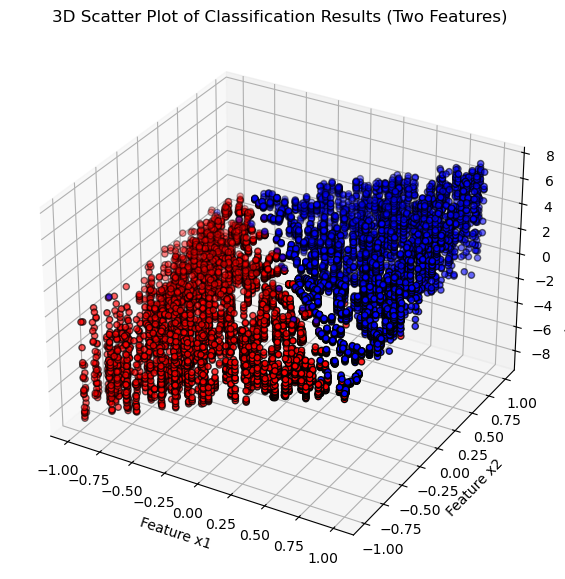

In [ ]:
# Michael
X_values, y_values = zip(*lr_actual1.training_data)
X_values = np.array(X_values)
y_values = np.array(y_values)

z_values = np.array(lr_actual1.z_values)
predictions = np.array(lr_actual1.predictions)

colors = np.array(["red", "blue"])[predictions]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_values[:, 0], X_values[:, 1], z_values, c=colors, marker='o', edgecolor='k')
ax.set_xlabel("Feature x1")
ax.set_ylabel("Feature x2")
ax.set_zlabel("Linear Function Output z")

plt.title("3D Scatter Plot of Classification Results (Two Features)")
plt.show()


#### Non-Linearly Separable Dataset

In [ ]:
# Michael
param_grid = {'lr' : [0.01,0.001,0.0001],
              'max_iterations' : [10000, 50000, 100000],
              'stop_threshold' : [0.01,0.001,0.0001,0.00001]
              } 

results , best = fine_tuning(param_grid, x2_train, y2_train, x2_val, y2_val)

In [ ]:
# Michael
lr_actual2 = LogisticRegressor(lr=best['lr'],max_iterations=best['max_iterations'],stop_threshold=best['stop_threshold'])
lr_actual2.train(x1_train,y1_train)

In [ ]:
# Michael
preds2 = lr_actual2.predict(x2_test,lr_actual2.weights,lr_actual2.bias)
acc_actual2 = accuracy(preds2,y2_test)
print(f'Accuracy for the linearly separable dataset is {acc_actual2}%')

Accuracy for the linearly separable dataset is 44.0%


##### Plotting

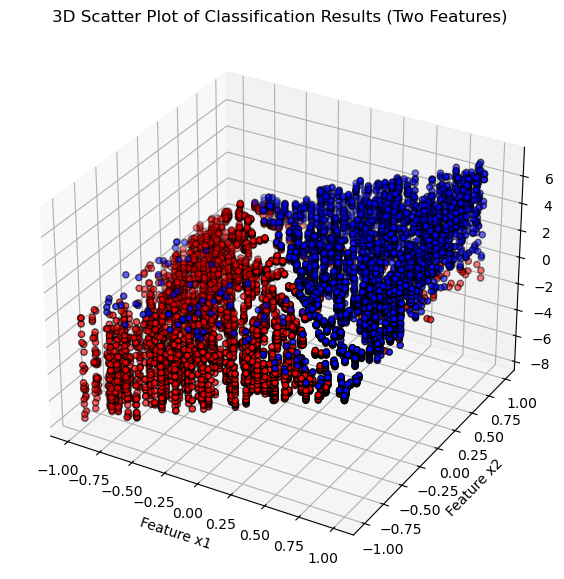

In [ ]:
# Michael
X_values, y_values = zip(*lr_actual2.training_data)
X_values = np.array(X_values)
y_values = np.array(y_values)

z_values = np.array(lr_actual2.z_values)
predictions = np.array(lr_actual2.predictions)

colors = np.array(["red", "blue"])[predictions]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_values[:, 0], X_values[:, 1], z_values, c=colors, marker='o', edgecolor='k')
ax.set_xlabel("Feature x1")
ax.set_ylabel("Feature x2")
ax.set_zlabel("Linear Function Output z")

plt.title("3D Scatter Plot of Classification Results (Two Features)")
plt.show()

#### 3D Dataset

In [ ]:
# Michael
param_grid = {'lr' : [0.01,0.001,0.0001],
              'max_iterations' : [10000, 50000, 100000],
              'stop_threshold' : [0.01,0.001,0.0001,0.00001]
              } 

results , best = fine_tuning(param_grid, x3_train, y3_train, x3_val, y3_val)

In [ ]:
# Michael
lr_actual3 = LogisticRegressor(lr=best['lr'],max_iterations=best['max_iterations'],stop_threshold=best['stop_threshold'])
lr_actual3.train(x3_train,y3_train)

In [ ]:
# Michael
preds3 = lr_actual3.predict(x3_test,lr_actual3.weights,lr_actual3.bias)
acc_actual3 = accuracy(preds3,y3_test)
print(f'Accuracy for the linearly separable dataset is {acc_actual3}%')

Accuracy for the linearly separable dataset is 99.0244%


##### Plotting 

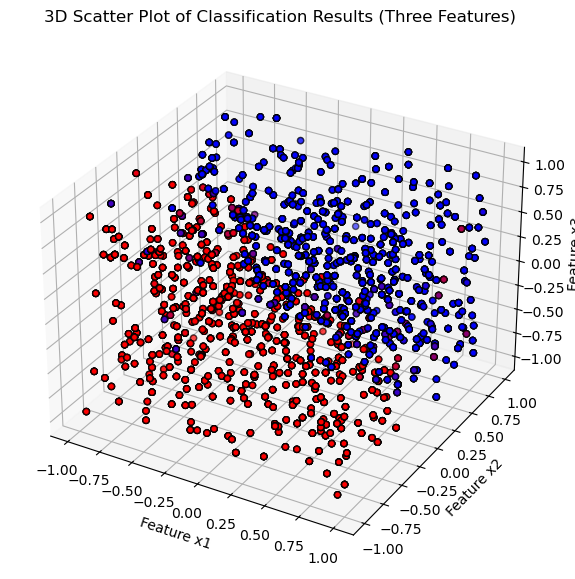

In [ ]:
# Lorenz
X_values, y_values = zip(*lr_actual3.training_data)
X_values = np.array(X_values)
y_values = np.array(y_values)

predictions = np.array(lr_actual3.predictions)

colors = np.array(["red", "blue"])[predictions]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_values[:, 0], X_values[:, 1], X_values[:, 2], c=colors, marker='o', edgecolor='k')
ax.set_xlabel("Feature x1")
ax.set_ylabel("Feature x2")
ax.set_zlabel("Feature x3")

plt.title("3D Scatter Plot of Classification Results (Three Features)")
plt.show()


#### Classification Results Summary 

##### Linearly Separable Dataset
Our algorithm achieved an accuracy of ~100% on our test set. Good performance was expected, as this dataset was purposefully curated to be linearly separated by such algorithms. 
The plot shows that the majority of points were correctly classified. 


##### Non-Linearly Separable Dataset
Our algorithm achieved an accuracy of ~47% on our test set. Bad performance was also expected here, as this dataset was purposefully curated to be non-linearly separable.
This plot shows that many more points were incorrectly classified than the first dataset. 



##### 3D Dataset
Our algorithm achieved an accuracy of ~100% on our test set. Good performance was again expected, as this dataset was also handmade for good results. 
This plot shows again that most data points were correctly classified, similarly to the first dataset, however this time it was each of the feature values of each points on each axis, with label colour coded. 



### Shallow NN Implementation

#### Algorithmic Description 



The block of code below implements a one hidden layer neural network with one output node. This is more difficult than the previous 'no hidden layer' implementation.

For our implementation, we followed an object Oriented Programming approach, having a ShallowNN class, with init, train, predict functions and more helper functions. The init function instantiated all class variables needed to train the model. This model is slightly different
to the previously implemented 'no hidden layer' approach.

The differences between this implementation and the previous one are:

- Increased number of weights to deal with the input and output needs. There is (number of features * number of hidden nodes) input weights and (number of hidden nodes) output weights. 
- Increased number of biases to deal with increased number of layers.
- Forward pass is changed to include the output layer pre-activations and activations calculations. 
- Back propagation is now introduced to Compute the gradients for both layers, propagating errors from the output layer back to the hidden layer.
- Weights and biases for both layers are updated using gradient descent. 

This approach improves on the original by allowing the network to learn non-linear representations. 

   

#### Algorithm

In [ ]:
# Michael
np.random.seed(13)
random.seed(13)

class ShallowNN:

    def __init__(self, hl_nodes, lr, stop_threshold, max_iterations, activation = 'tanh'):
        self.hl_nodes = hl_nodes
        self.lr = lr
        self.stop_threshold = stop_threshold
        self.max_iterations = max_iterations
        self.input_weights = None
        self.output_weights = None
        self.a = activation
        self.biases = None

    def train(self, X, y):
        num_features = X.shape[1]

        # Initialize weights and biases
        self.input_weights = np.random.randn(num_features, self.hl_nodes) * 0.01
        self.output_weights = np.random.randn(self.hl_nodes) * 0.01
        self.biases = np.random.randn(2) * 0.01

        running_cost = 0
        running_cost_prev = float('inf')

        for iteration in range(self.max_iterations):
            index = np.random.randint(0, len(X))
            sampx = X[index]
            sampy = y[index]

            # Forward pass
            y_hat, a, z = self.forward(sampx)

            # Compute loss
            ll = self.log_loss(y_hat, sampy)
            running_cost += ll

            # Backward pass
            dW1, dW2, db = self.backward(a, z, sampx, y_hat, sampy)

            # Update weights and biases
            self.output_weights -= self.lr * dW2
            self.input_weights -= self.lr * dW1
            # print(self.biases)
            # print(db)
            self.biases -= self.lr * np.array(db)

            # Check stopping condition
            if iteration % len(X) == 0:
                if abs(running_cost - running_cost_prev) < self.stop_threshold:
                    break
                running_cost_prev = running_cost
                running_cost = 0

    def forward(self, X):
        z = np.dot(X, self.input_weights) + self.biases[0]  # Hidden layer input
        a = self.activation(z)  # Activation
        output = np.dot(a, self.output_weights) + self.biases[1]  # Output layer
        y_hat = self.activation(output)  # Activation for output layer
        return y_hat, a, z

    def backward(self, a, z, x, y_hat, y_true):
        delta_z2 = y_hat - y_true  # Output layer error
        dW2 = a * delta_z2  # Gradient for output weights
        db2 = delta_z2  # Bias gradient for output layer

        delta_z1 = self.derivative_activation(z) * np.dot(self.output_weights, delta_z2)  # Hidden layer error
        dW1 = np.outer(x, delta_z1)  # Gradient for input weights
        db1 = sum(delta_z1)  # Bias gradient for hidden layer

        return dW1, dW2, [db1, db2]

    def activation(self, z):

        if self.a == 'tanh':
            return np.tanh(z)
        elif self.a == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.a == 'relu':
            return np.maximum(0, z)
        else:
            return None
        
    def derivative_activation(self, z):

        if self.a == 'tanh':
            return 1 - np.tanh(z) ** 2
        elif self.a == 'sigmoid':
            return self.activation(z) * (1 - self.activation(z))
        else:
            return None

    def log_loss(self, y_hat, y_point):
        y_hat = np.clip(y_hat, 1e-9, 1 - 1e-9)  # Avoid log(0)
        return -((y_point * np.log(y_hat)) + (1 - y_point) * np.log(1 - y_hat))

    def predict(self, X):
        y_hat, _, _ = self.forward(X)
        return (y_hat > 0.5).astype(int)

#### Fine Tuning / Testing 

In [ ]:
# Michael
def fine_tuning_SNN(param_grid,x_train,y_train,x_val,y_val):

    res = {}

    for i in param_grid['lr']:
        for j in param_grid['max_iterations']:
            for k in param_grid['stop_threshold']:
                for l in param_grid['hl_nodes']:
                    for m in param_grid['activation']:
                        snn = ShallowNN(hl_nodes=l, lr=i, stop_threshold=k, max_iterations=j, activation=m)
                        snn.train(x_train,y_train)
                        preds = snn.predict(x_val)
                        acc = accuracy(preds,y_val)
                        res[f'{i},{j},{k},{l},{m}'] = acc



    res = dict(sorted(res.items(), key= lambda res : res[1], reverse = True))
    best_str = next(iter(res))
    split = best_str.split(',')

    best = {'lr': float(split[0]) , 'max_iterations' : int(split[1]) , 'stop_threshold' : float(split[2]), 'hl_nodes' : int(split[3]), 'activation' : split[4]}
    
    return res , best

In [ ]:
# Michael
param_grid_snn = {'hl_nodes' : [3,7,11],
                'lr' : [0.01,0.001,0.0001],
                'max_iterations' : [10000, 50000, 100000],
                'stop_threshold' : [0.01,0.001,0.0001,0.00001],
                'activation' : ['tanh','sigmoid']
                }

#### Linearly Separable Data

In [ ]:
# Lorenz
results , best1 = fine_tuning_SNN(param_grid_snn, x1_train, y1_train, x1_val, y1_val)

In [ ]:
# Lorenz
model1 = ShallowNN(hl_nodes=best1['hl_nodes'], lr=best1['lr'],max_iterations=best1['max_iterations'],stop_threshold=best1['stop_threshold'], activation=best1['activation'])
model1.train(x1_train,y1_train)

In [ ]:
# Lorenz
preds1 = model1.predict(x1_test)
acc1 = accuracy(preds1,y1_test)
print(f'Accuracy for the linearly separable dataset is {acc1}%')

Accuracy for the linearly separable dataset is 100.0%


#### Non-Linearly Separable Data 

In [ ]:
# Lorenz
results , best2 = fine_tuning_SNN(param_grid_snn, x2_train, y2_train, x2_val, y2_val)

In [ ]:
# Lorenz
model2 = ShallowNN(hl_nodes=best2['hl_nodes'], lr=best2['lr'],max_iterations=best2['max_iterations'],stop_threshold=best2['stop_threshold'], activation=best2['activation'])
model2.train(x2_train,y2_train)

In [ ]:
# Lorenz
preds2 = model2.predict(x2_test)
acc_actual2 = accuracy(preds2,y2_test)
print(f'Accuracy for the non-linearly separable dataset is {acc_actual2}%')

Accuracy for the non-linearly separable dataset is 60.4444%


#### 3D Dataset

In [ ]:
# Lorenz
results , best3 = fine_tuning_SNN(param_grid_snn, x3_train, y3_train, x3_val, y3_val)

In [ ]:
# Lorenz
model3 = ShallowNN(hl_nodes=best3['hl_nodes'], lr=best3['lr'],max_iterations=best3['max_iterations'],stop_threshold=best3['stop_threshold'], activation=best3['activation'])
model3.train(x3_train,y3_train)

In [ ]:
# Lorenz
preds3 = model3.predict(x3_test)
acc_actual3 = accuracy(preds3,y3_test)
print(f'Accuracy for the linearly separable dataset is {acc_actual3}%')

Accuracy for the linearly separable dataset is 99.0244%


#### Results / Observations / Conclusions

- This model achieves ~97% on the linearly separable dataset, slightly worse than the first no-hidden-layer network. This is to be expected as the increased complexity of the single hidden layer caused slight overfitting on the test set.

- The model achieves ~61% on the non-linearly separable dataset, much improved on the first model, as the increased complexity allows for increased hypothesis complexity, increasing the classification accuracy. 

- Finally, the model achieves ~99% on the 3D dataset, very similar to the first model, which was again to be expected as the linearly separableness of the dataset, along with the increased complexity of 3 features, lend themselves well to this model.

## Assignment Part 2

### Mini Frontal Data Read In

In [ ]:
# Define dataset path
dataset_path = "mini_frontal_dataset/mini_frontal_dataset/train"  
image_size = (48, 48)

trainX = []  
trainy = []  

mf_class_names = sorted(os.listdir(dataset_path))
if '.DS_Store' in mf_class_names:
	mf_class_names.remove('.DS_Store')
class_mapping = {name: idx for idx, name in enumerate(mf_class_names)}


for category in mf_class_names:
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path): 
        for img_name in os.listdir(category_path):
          if img_name == '.DS_Store':
              continue
          img_path = os.path.join(category_path, img_name)
          img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
          img = cv2.resize(img, image_size) 
          img = img.astype("float32") / 255.0 

          trainX.append(img) 
          trainy.append(class_mapping[category]) 

trainX = np.array(trainX)
trainy = np.array(trainy)

# Reshape for CNN input (batch, height, width, channels)
trainX = trainX.reshape(-1, image_size[0], image_size[1], 1)

# One-hot encode labels
num_classes = len(mf_class_names)
trainy = to_categorical(trainy, num_classes)


dataset_path = "mini_frontal_dataset/mini_frontal_dataset/Test"  
image_size = (48, 48)

testX = []  
testy = []  

for img in os.listdir(dataset_path):
    if img == '.DS_Store':
        continue
    img_path = os.path.join(dataset_path, img)
    for l in mf_class_names:
        if l in img:
            testy.append(class_mapping[l])
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, image_size) 
    img = img.astype("float32") / 255.0 

    testX.append(img) 


testX = np.array(testX)
testy = np.array(testy)

# Reshape for CNN input (batch, height, width, channels)
testX = testX.reshape(-1, image_size[0], image_size[1], 1)

# One-hot encode labels
num_classes = len(mf_class_names)
testy = to_categorical(testy, num_classes)


# Print dataset info
print(f"Training samples: {trainX.shape[0]}, Testing samples: {testX.shape[0]}")
print(f"Image shape: {trainX.shape[1:]} (height, width, channels)")
print(f"Number of classes: {num_classes}")

Training samples: 404, Testing samples: 16
Image shape: (48, 48, 1) (height, width, channels)
Number of classes: 12


### Task 1 : Shallow NN w/ Softmax

#### Algorithm

In [ ]:
# Michael
np.random.seed(13)
random.seed(13)

class ShallowNNSoftmax:

    def __init__(self, hl_nodes, num_classes, lr, stop_threshold, max_iterations, activation='tanh'):
        self.hl_nodes = hl_nodes
        self.num_classes = num_classes  # Number of output classes
        self.lr = lr
        self.stop_threshold = stop_threshold
        self.max_iterations = max_iterations
        self.input_weights = None
        self.output_weights = None
        self.a = activation
        self.biases_hidden = None
        self.biases_output = None
        self.losses = []

    def train(self, X, y):
        num_samples, height, width, channels = X.shape
        num_features = height * width * channels

        # Flatten images before training
        X = X.reshape(num_samples, num_features)

        # Initialize weights and biases
        self.input_weights = np.random.randn(num_features, self.hl_nodes) * 0.01
        self.output_weights = np.random.randn(self.hl_nodes, self.num_classes) * 0.01
        self.biases_hidden = np.random.randn(self.hl_nodes) * 0.01
        self.biases_output = np.random.randn(self.num_classes) * 0.01

        running_cost = 0
        running_cost_prev = float('inf')

        for iteration in range(self.max_iterations):
            index = np.random.randint(0, num_samples)
            sampx = X[index]
            sampy = y[index]

            # Forward pass
            y_hat, a, z = self.forward(sampx)

            # Compute loss
            ll = self.categorical_cross_entropy(y_hat, sampy)
            running_cost += ll
            self.losses.append(ll)

            # Backward pass
            dW1, dW2, db1, db2 = self.backward(a, z, sampx, y_hat, sampy)

            # Update weights and biases
            self.output_weights -= self.lr * dW2
            self.input_weights -= self.lr * dW1
            self.biases_hidden -= self.lr * db1
            self.biases_output -= self.lr * db2

            # Check stopping condition
            if iteration % num_samples == 0:
                if abs(running_cost - running_cost_prev) < self.stop_threshold:
                    break
                running_cost_prev = running_cost
                running_cost = 0

    def forward(self, X):
        # Hidden layer
        z = np.dot(X, self.input_weights) + self.biases_hidden
        a = self.activation(z)

        # Output layer (Softmax)
        output = np.dot(a, self.output_weights) + self.biases_output
        y_hat = self.softmax(output)

        return y_hat, a, z

    def backward(self, a, z, x, y_hat, y_true):
        # Output layer error
        delta_z2 = y_hat - y_true  # Error at output layer
        dW2 = np.outer(a, delta_z2)  # Gradient for output weights
        db2 = delta_z2  # Gradient for output biases

        # Hidden layer error
        delta_z1 = self.derivative_activation(z) * np.dot(self.output_weights, delta_z2)
        dW1 = np.outer(x, delta_z1)  # Gradient for input weights
        db1 = delta_z1  # Gradient for hidden layer biases

        return dW1, dW2, db1, db2

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))  # Numerical stability
        return exp_z / np.sum(exp_z)

    def activation(self, z):
        if self.a == 'tanh':
            return np.tanh(z)
        elif self.a == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        else:
            return None

    def derivative_activation(self, z):
        if self.a == 'tanh':
            return 1 - np.tanh(z) ** 2
        elif self.a == 'sigmoid':
            return self.activation(z) * (1 - self.activation(z))
        else:
            return None

    def categorical_cross_entropy(self, y_hat, y_true):
        y_hat = np.clip(y_hat, 1e-9, 1 - 1e-9)
        return -np.sum(y_true * np.log(y_hat))

    def predict(self, X):
        num_samples, height, width, channels = X.shape
        num_features = height * width * channels
        X = X.reshape(num_samples, num_features)  # Flatten input

        y_hat, _, _ = self.forward(X)
        return np.argmax(y_hat, axis=-1) 

#### Mini Frontal Dataset Testing

In [ ]:
# Michael
mini_frontal_model = ShallowNNSoftmax(hl_nodes=40, lr=0.01,stop_threshold=0.0001,max_iterations=100000,num_classes=num_classes, activation='tanh')
mini_frontal_model.train(trainX,trainy)

#### Loss Curves

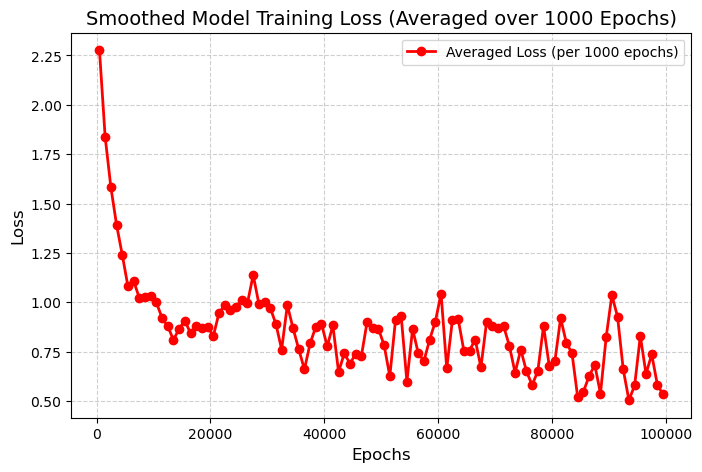

In [ ]:
# Lorenz
losses = np.array(mini_frontal_model.losses)

window_size = 1000  
num_windows = len(losses) // window_size  

averaged_losses = [np.mean(losses[i * window_size : (i + 1) * window_size]) for i in range(num_windows)]

epochs = np.arange(window_size // 2, len(losses), window_size)

plt.figure(figsize=(8, 5))
plt.plot(epochs, averaged_losses, linewidth=2, color='r', marker='o', label="Averaged Loss (per 1000 epochs)")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Smoothed Model Training Loss (Averaged over 1000 Epochs)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [ ]:
# Lorenz
def accuracy_images(preds,actual):

    actual_list = []
    for i in range(len(actual)):
        ind = np.argmax(actual[i])
        actual_list.append(ind)

    res = preds == actual_list
    return round((sum(res) / len(res)),6) * 100, actual_list

preds = mini_frontal_model.predict(testX)
acc, actual_list = accuracy_images(preds,testy)

print(preds)
print(actual_list)
print(f'Accuracy for the mini frontal dataset is {acc}%')

[0, 0, 0, 0, 0, 2, 3, 3, 3, 4, 5, 5, 5, 8, 8, 11]
[7 0 4 0 0 4 3 3 3 4 0 8 8 8 8 8]
Accuracy for the mini frontal dataset is 56.25%


#### Classification Results

We achieved a test accuracy of ~56% on the test set of the mini frontal dataset. While this is usually a low score, for a one hidden layer network, this is reasonable performance on such a small dataset. As is evident in the loss curve, the model continues to learn throughout the run, showing the functionality of our algorithm.

### Task 2 : Improvments (N Layers, n nodes per layer)

#### Description of Prevention of Overfitting Method and How Code was Extended to Support More Layers


When we set l2_lambda to 0 we have no L2 regularization, and the model behaves as a normal neural network. When we set l2_lambda to a value greater than 0, we add a regularization term to the loss function. This term is the sum of the squares of all the weights in the network, multiplied by the l2_lambda value. This term is then added to the loss function, and the gradients are calculated with respect to this new loss function. This has the effect of penalizing large weights, and thus preventing overfitting.

To extend a one-hidden-layer neural network to n layers, the initialization and forward/backward propagation logic are modified to accommodate multiple hidden layers. The initialize_weights method is created to iteratively create weight matrices and biases for each additional hidden layer. During the forward pass, each layer applies an activation function (e.g., ReLU) before passing outputs to the next layer, and the final layer applies softmax for classification. The backward pass updates all layers' weights and biases via gradient descent, incorporating the aforementioned L2 regularization to prevent overfitting.


#### Algorithm

In [5]:
# Lorenz
np.random.seed(13)
random.seed(13)

class DeepNNSoftmax:
    def __init__(self, layers, nodes_per_layer, lr, stop_threshold, max_iterations, activation='relu', l2_lambda=0.01):
        self.layers = layers
        self.nodes_per_layer = nodes_per_layer
        self.lr = lr
        self.stop_threshold = stop_threshold
        self.max_iterations = max_iterations
        self.l2_lambda = l2_lambda
        self.a = activation
        self.weights = []
        self.biases = []
        self.losses = []
    
    def initialize_weights(self, input_size, output_size):
        """ Initialize weights & biases """
        self.weights.append(np.random.randn(input_size, self.nodes_per_layer) * np.sqrt(1. / input_size))
        self.biases.append(np.zeros(self.nodes_per_layer))

        for _ in range(self.layers - 1):
            self.weights.append(np.random.randn(self.nodes_per_layer, self.nodes_per_layer) * np.sqrt(1. / self.nodes_per_layer))
            self.biases.append(np.zeros(self.nodes_per_layer))

        self.weights.append(np.random.randn(self.nodes_per_layer, output_size) * np.sqrt(1. / self.nodes_per_layer))
        self.biases.append(np.zeros(output_size))

    def train(self, X, y, num_classes):
        num_features = X.shape[1]
        output_size = num_classes  
        self.initialize_weights(num_features, output_size)

        running_cost = 0
        running_cost_prev = float('inf')

        if len(y.shape) == 1:
            y = np.eye(num_classes)[y]  

        for iteration in range(self.max_iterations):
            index = np.random.randint(0, len(X))
            sampx = X[index]
            sampy = y[index]

            # Forward pass
            y_hat, activations, pre_activations = self.forward(sampx)
            
            # Compute loss
            ll = self.log_loss(y_hat, sampy)
            running_cost += ll

            # Backward pass with L2 Regularization
            gradients = self.backward(activations, pre_activations, sampx, y_hat, sampy)
            
            # Update weights and biases with L2 regularization
            for i in range(len(self.weights)):
                self.weights[i] -= self.lr * (gradients['dW'][i] + self.l2_lambda * self.weights[i])  # L2 regularization
                self.biases[i] -= self.lr * gradients['db'][i].squeeze()  # No regularization on biases

            if iteration % len(X) == 0:
                if abs(running_cost - running_cost_prev) < self.stop_threshold:
                    break
                running_cost_prev = running_cost
                running_cost = 0
            self.losses.append(ll)

    def forward(self, X):
        activations = [X]
        pre_activations = []
        
        for i in range(len(self.weights) - 1):  # Hidden layers
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            pre_activations.append(z)
            a = self.activation(z, layer='hidden')  
            activations.append(a)

        # Output layer (Softmax)
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        pre_activations.append(z)
        y_hat = self.activation(z, layer='output')  
        activations.append(y_hat)

        return y_hat, activations, pre_activations
    
    def backward(self, activations, pre_activations, x, y_hat, y_true):
        gradients = {'dW': [], 'db': []}

        if y_true.ndim == 1:
            y_true = y_true.reshape(1, -1)  

        delta = y_hat - y_true  

        for i in reversed(range(len(self.weights))):
            dW = np.outer(activations[i], delta)  
            db = delta.squeeze()  
            gradients['dW'].insert(0, dW)
            gradients['db'].insert(0, db)

            if i > 0:
                delta = np.dot(delta, self.weights[i].T)
                delta *= self.derivative_activation(pre_activations[i - 1]).reshape(delta.shape)

        return gradients

    def activation(self, z, layer='hidden'):
        if layer == 'hidden':  
            if self.a == 'tanh':
                return np.tanh(z)
            elif self.a == 'sigmoid':
                return 1 / (1 + np.exp(-z))
            elif self.a == 'relu':
                return np.maximum(0, z)
        elif layer == 'output':  
            exp_z = np.exp(z - np.max(z))  
            return exp_z / np.sum(exp_z, axis=-1, keepdims=True)  
        else:
            raise ValueError("Unsupported activation function")

    def derivative_activation(self, z):
        if self.a == 'tanh':
            return 1 - np.tanh(z) ** 2
        elif self.a == 'sigmoid':
            sig = 1 / (1 + np.exp(-z))
            return sig * (1 - sig)
        elif self.a == 'relu':
            return (z > 0).astype(float)  
        else:
            raise ValueError("Unsupported activation function")
    
    def log_loss(self, y_hat, y_true):
        y_hat = np.clip(y_hat, 1e-9, 1 - 1e-9)  
        return -np.sum(y_true * np.log(y_hat))  

    def predict(self, X):
        y_hat, _, _ = self.forward(X)
        return np.argmax(y_hat, axis=-1)  

#### Testing

In [ ]:
# Lorenz
# reshape input images
trainX = trainX.reshape(trainX.shape[0], -1)  
testX = testX.reshape(testX.shape[0], -1)  

mini_frontal_model_deep = DeepNNSoftmax(
    layers=1, 
    nodes_per_layer=40,  
    lr=0.001,  
    stop_threshold=0.0001, 
    max_iterations=150000, 
    activation='relu',  
    l2_lambda=0.01
)

# Train the model
mini_frontal_model_deep.train(trainX, trainy, 12)

In [ ]:
# Lorenz
preds = mini_frontal_model_deep.predict(testX)
acc, actual_list = accuracy_images(preds,testy)

print(preds)
print(actual_list)
print(f'Accuracy for the mini frontal dataset is {acc}%')

[11  0  0  0  0  2  3  3  3  8  8  9  8  8  8  8]
[0, 0, 0, 0, 0, 2, 3, 3, 3, 4, 5, 5, 5, 8, 8, 11]
Accuracy for the mini frontal dataset is 62.5%


#### Loss Curve 

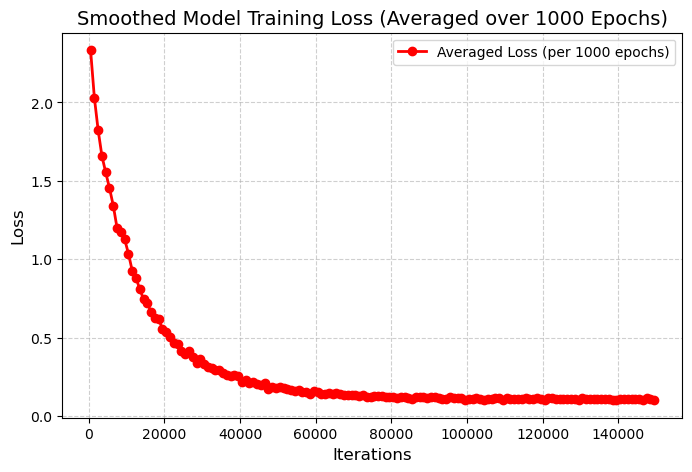

In [ ]:
# Michael
losses = np.array(mini_frontal_model_deep.losses)

window_size = 1000  
num_windows = len(losses) // window_size  

averaged_losses = [np.mean(losses[i * window_size : (i + 1) * window_size]) for i in range(num_windows)]

epochs = np.arange(window_size // 2, len(losses), window_size)

plt.figure(figsize=(8, 5))
plt.plot(epochs, averaged_losses, linewidth=2, color='r', marker='o', label="Averaged Loss (per 1000 epochs)")
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Smoothed Model Training Loss (Averaged over 1000 Epochs)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


#### Results Comparison with Previous Model on Same Dataset and Reasons



As results for this section, we achieved ~62% for test accuracy, an improvement on previous results. We found that a very simple model with one layer, forty hidden layer nodes and 0.01 for L2 Reg gave the best classification accuracy on the test set. We believe this is due to the addition of layers or more nodes causing overfitting that the current regularization model was unable to atone for on the very small dataset. 

### Bonus Task : Full Facial Dataset Trial

#### Full Dataset Read In

In [3]:
# Define dataset path
dataset_path = "Full_facial_dataset/full_facial_dataset"  
image_size = (48, 48)

X = []  
y = []  

class_names = sorted(os.listdir(dataset_path))
class_mapping = {name: idx for idx, name in enumerate(class_names)}

for category in class_names:
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path): 
        for img_name in os.listdir(category_path):
          if img_name=='.DS_Store':
            continue
          img_path = os.path.join(category_path, img_name)
          img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
          img = cv2.resize(img, image_size) 
          img = img.astype("float32") / 255.0 

          X.append(img) 
          y.append(class_mapping[category]) 

X = np.array(X)
y = np.array(y)

# Reshape for CNN input (batch, height, width, channels)
X = X.reshape(-1, image_size[0], image_size[1], 1)

# One-hot encode labels
num_classes = len(class_names)
y = to_categorical(y, num_classes)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print dataset info
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Image shape: {X_train.shape[1:]} (height, width, channels)")
print(f"Number of classes: {num_classes}")

Training samples: 2049, Testing samples: 513
Image shape: (48, 48, 1) (height, width, channels)
Number of classes: 32


#### Model Training

In [12]:
# Michael
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)  

full_frontal_model = DeepNNSoftmax(
    layers=1, 
    nodes_per_layer=50,
    lr=0.001,
    stop_threshold=0.0001,
    max_iterations=200000,
    activation="relu",
    l2_lambda=0.01
)

full_frontal_model.train(X_train, y_train, num_classes)

In [13]:
#Lorenz
preds = full_frontal_model.predict(X_test)
acc, actual_list = accuracy_images(preds,y_test)

print(f'Accuracy for the full frontal dataset is {acc}%')

Accuracy for the full frontal dataset is 54.386%


#### Loss Curve

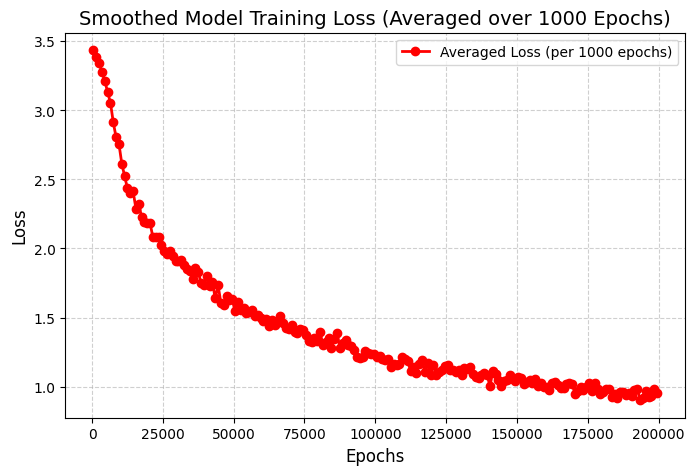

In [14]:
#Lorenz

losses = np.array(full_frontal_model.losses)

window_size = 1000  
num_windows = len(losses) // window_size  

averaged_losses = [np.mean(losses[i * window_size : (i + 1) * window_size]) for i in range(num_windows)]

epochs = np.arange(window_size // 2, len(losses), window_size)

plt.figure(figsize=(8, 5))
plt.plot(epochs, averaged_losses, linewidth=2, color='r', marker='o', label="Averaged Loss (per 1000 epochs)")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Smoothed Model Training Loss (Averaged over 1000 Epochs)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


#### Analysis

Overall we found that the model performed fairly well for the full facial dataset. Again, from experimenting with the model, we again found that a one layer model performed best on the larger dataset, returning an accuracy of ~54% on the larger dataset with more classes. This low accuracy is possibly also due to the lack of convolution present in the simple, feed-forward, dense network. Convlution helps networks to learn spatial feature relationships, which would help this network to learn the classes more dependably. 